# Example 9.2: Bootstrapping on the 1000-state Random Walk:
## Semi-gradient TD(0)

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import sys

In [2]:
NUM_STATES = 1000
TRUE_VALUE = (np.arange(1, NUM_STATES + 1) / 500) - 1

class Env:
    def __init__(self):
        self.state = 500  # We start from 500

    def reset(self):
        self.state = 500

    def step(self):
        """ Return (state, reward, done) """
        self.state = random.randint(self.state - 100, self.state + 100)
        self.state = max(self.state, 0)
        self.state = min(self.state, NUM_STATES + 1)
        if self.state == NUM_STATES + 1:
            return self.state, 1, True
        elif self.state == 0:
            return self.state, -1, True
        else:
            return self.state, 0, False

The value function. We use state aggregation, which is a special case of linear function approximation.

In [3]:
class ValueFunction:
    def __init__(self, num_group=10):
        self.num_group =  num_group
        self.group_size = NUM_STATES // num_group
        self.w = np.zeros(num_group)  # The weight vector

    def update(self, state, x):
        # Due to State aggregation, only the state's group has gradient 1, all others' component are 0,
        # We skip the vector dot product here.
        self.w[(state - 1) // self.group_size] += x

    def get_value(self, state):
        """ return the approximation of v(state, weight)"""
        if state == 0 or state == NUM_STATES + 1:
            return 0
        return self.w[(state - 1) // self.group_size]

    def reset(self):
        self.w.fill(0)

The semi-gradient TD(0) algorithm:

In [4]:
def semi_gradient_TD_0_prediction(env, value_func, alpha=2e-4, gamma=1, num_episode=100000):
    for _ in range(num_episode):
        env.reset()
        while True:
            pre_state= env.state
            state, reward, done = env.step()
            value_func.update(pre_state,
                              alpha * (reward + gamma * value_func.get_value(state) - value_func.get_value(pre_state)))
            if done:
                break

Draw the left figure: <br />
Notice asymptotic values of semi-gradient TD are worse than Monte Carlo values in 9.1.

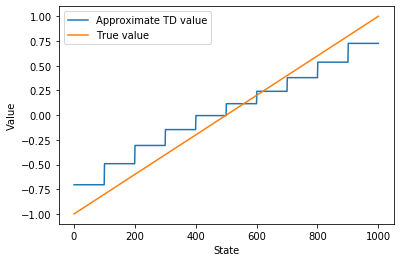

In [5]:
env = Env()
value_func = ValueFunction()
semi_gradient_TD_0_prediction(env, value_func)
x = np.arange(1, NUM_STATES + 1)
y = np.zeros(NUM_STATES)
for i in range(NUM_STATES):
    y[i] = value_func.get_value(i + 1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, label='Approximate TD value')
ax.plot(x, TRUE_VALUE, label='True value')
ax.set_xlabel('State')
ax.set_ylabel('Value')
ax.legend(loc='best')
plt.show()

## n-step semi-gradient TD prediction

In [6]:
def n_step_semi_gradient_TD_prediction(env, n, value_func, alpha, gamma=1, num_episodes=10):
    for _ in range(num_episodes):
        env.reset()
        t, T, done = 0, float('inf'), False
        episode = []
        while True:
            if not done:
                pre_state = env.state
                state, reward, done = env.step()
                episode.append((pre_state, reward))
                if done:
                    T = t + 1
            update_time = t - n
            if update_time >= 0:
                target, discount_factor = 0, 1
                for i in range(update_time, min(T, update_time + n)):
                    target += discount_factor * episode[i][1]
                    discount_factor *= gamma
                if update_time + n < T:
                    target += discount_factor * value_func.get_value(episode[update_time + n][0])
                value_func.update(episode[update_time][0],
                                  alpha * (target - value_func.get_value(episode[update_time][0])))
            t += 1
            if update_time == T - 1:
                break

Draw the right figure: <br />
The data are averages over 100 runs, 10 episodes.

Progress: 90%

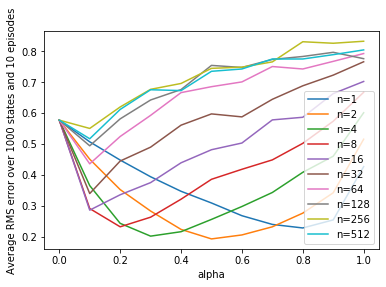

In [7]:
def compute_error(value_func):
    v_estimated = np.zeros(NUM_STATES)
    for i in range(1, NUM_STATES + 1):
        v_estimated[i - 1] = value_func.get_value(i)
    return np.sqrt(np.sum((v_estimated - TRUE_VALUE) ** 2) / NUM_STATES)


env = Env()
value_func = ValueFunction(20)  # 20 groups
fig, ax = plt.subplots(1, 1)
alphas = np.arange(0, 1.1, 0.1)  # alpha = {0, 0.1, ..., 1.0} 
for i in range(10):  # n = {1, 2, 4, 8, ..., 512}
    n = 2 ** i
    print('\rProgress: {}%'.format(i * 10), end='')
    sys.stdout.flush()
    errors = []
    for alpha in alphas:
        lst = []
        for run in range(100):  # average over 100 runs
            value_func.reset()
            n_step_semi_gradient_TD_prediction(env, n, value_func, alpha=alpha)
            lst.append(compute_error(value_func))
        errors.append(np.mean(lst))
    ax.plot(alphas, errors, label='n={}'.format(n))
ax.set_xlabel('alpha')
ax.set_ylabel('Average RMS error over 1000 states and 10 episodes')
ax.legend(loc='best')
plt.show()